Starting ARDNS-G-Quantum simulation...
ARDNS-G-Quantum Episode 0: Goals 1/1 (100.0%)
ARDNS-G-Quantum Episode 500: Goals 455/501 (90.8%)
ARDNS-G-Quantum Episode 1000: Goals 955/1001 (95.4%)
ARDNS-G-Quantum Episode 1500: Goals 1455/1501 (96.9%)
ARDNS-G-Quantum Episode 2000: Goals 1955/2001 (97.7%)
ARDNS-G-Quantum Episode 2500: Goals 2454/2501 (98.1%)
ARDNS-G-Quantum Episode 3000: Goals 2954/3001 (98.4%)
ARDNS-G-Quantum Episode 3500: Goals 3428/3501 (97.9%)
ARDNS-G-Quantum Episode 4000: Goals 3828/4001 (95.7%)
ARDNS-G-Quantum Episode 4500: Goals 4323/4501 (96.0%)
ARDNS-G-Quantum Episode 5000: Goals 4821/5001 (96.4%)
ARDNS-G-Quantum Episode 5500: Goals 5321/5501 (96.7%)
ARDNS-G-Quantum Episode 6000: Goals 5821/6001 (97.0%)
ARDNS-G-Quantum Episode 6500: Goals 6321/6501 (97.2%)
ARDNS-G-Quantum Episode 7000: Goals 6821/7001 (97.4%)
ARDNS-G-Quantum Episode 7500: Goals 7320/7501 (97.6%)
ARDNS-G-Quantum Episode 8000: Goals 7768/8001 (97.1%)
ARDNS-G-Quantum Episode 8500: Goals 8268/8501 (97.3%)
A

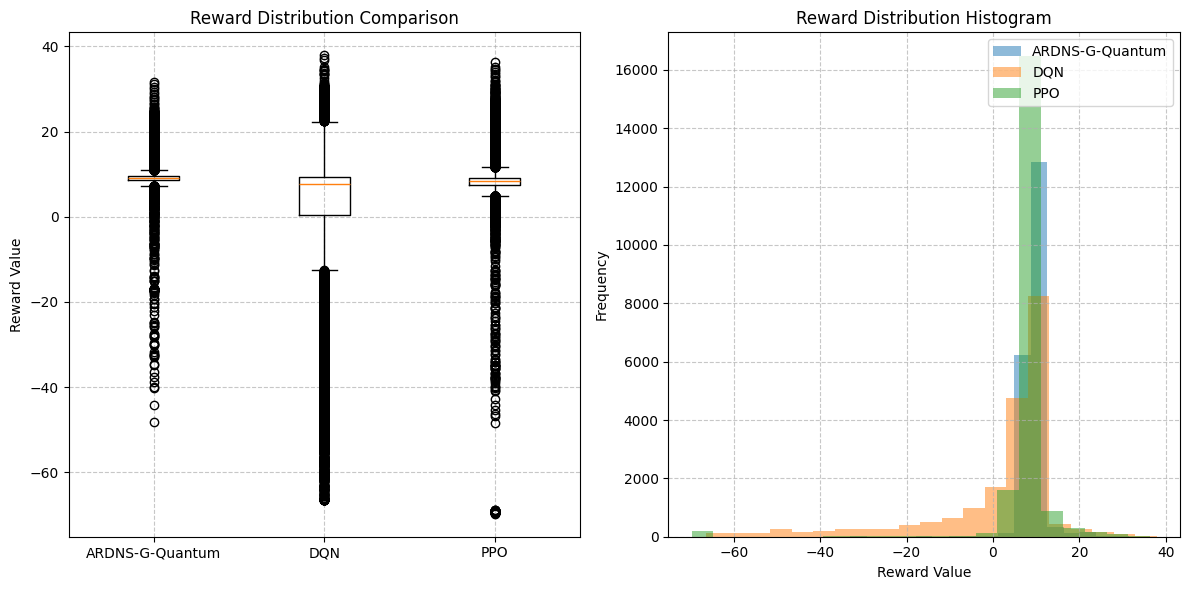

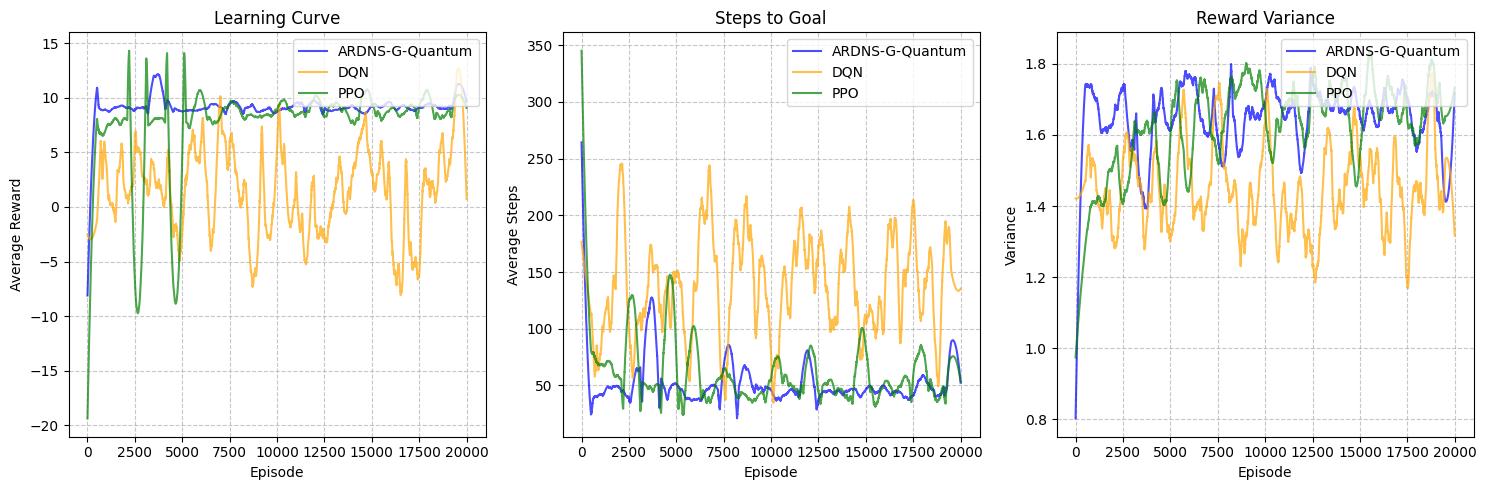

In [55]:
# Install required packages
!pip install qiskit==2.0.0 qiskit-aer==0.17.0 numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import scipy.stats as stats
from scipy.signal import savgol_filter
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import time

# Configure NumPy to detect numerical errors
np.seterr(all='raise')

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

class ARDNS_G_Quantum:
    def __init__(self, state_dim=2, action_dim=4, ms_dim=8, ml_dim=16,
                 use_gmm=True, use_dual_memory=True, use_variability_plasticity=True,
                 use_attention=True):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.ms_dim = ms_dim
        self.ml_dim = ml_dim
        self.use_attention = use_attention

        self.n_qubits_a = int(np.ceil(np.log2(action_dim)))
        self.qr_a = QuantumRegister(self.n_qubits_a, 'qa')
        self.simulator = AerSimulator()

        self.M_s = np.random.randn(ms_dim) * 0.1
        self.M_l = np.random.randn(ml_dim) * 0.1
        self.W_s_params = np.random.randn(ms_dim, state_dim) * 0.1
        self.W_l_params = np.random.randn(ml_dim, state_dim) * 0.1
        self.W_a_params = np.random.randn(action_dim, ms_dim + ml_dim) * 0.1

        if use_attention:
            self.attention_params = np.random.randn(ms_dim + ml_dim) * 0.1

        self.memory_buffer = deque(maxlen=100)
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}
        self.success_count = 0
        self.state_visits = {}

        self.params = {
            'base_eta': 0.7,
            'eta_r': 0.05,
            'alpha_s': 0.85,
            'alpha_l': 0.95,
            'beta': 0.1,
            'gamma': 0.01,
            'tau': 1.5,
            'epsilon': 1.0,
            'epsilon_min': 0.2,
            'epsilon_decay': 0.995,
            'clip_value': 5.0,
            'sigma_min': 0.01,
            'curiosity_factor': 0.75
        }

        self.episode = 0
        self.performance_history = []
        self.variance_history = []
        self.goal = (9, 9)

    def _create_action_circuit(self, params, input_state):
        circuit = QuantumCircuit(self.qr_a)
        input_state = input_state[:len(params[0])]
        combined_angles = np.zeros(self.n_qubits_a)
        for i in range(self.n_qubits_a):
            angle = np.sum(params[i] * input_state)
            combined_angles[i] += angle
        for i in range(self.n_qubits_a):
            circuit.ry(combined_angles[i], self.qr_a[i])
        return circuit

    def _measure_circuit(self, circuit, shots=16):
        cr = ClassicalRegister(self.n_qubits_a, 'c')
        meas_circuit = circuit.copy()
        meas_circuit.add_register(cr)
        meas_circuit.measure(self.qr_a, cr)
        job = self.simulator.run(meas_circuit, shots=shots)
        result = job.result().get_counts()
        probs = np.zeros(self.action_dim)
        for state, count in result.items():
            idx = min(int(state, 2), self.action_dim - 1)
            probs[idx] = count / shots
        return probs

    def update_state_visits(self, state):
        state_tuple = tuple(state)
        self.state_visits[state_tuple] = self.state_visits.get(state_tuple, 0) + 1

    def compute_state_entropy(self):
        total_visits = sum(self.state_visits.values())
        if total_visits == 0:
            return 0.0
        probs = np.array([count / total_visits for count in self.state_visits.values()])
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        return entropy

    def get_adaptive_parameters(self):
        success_rate = self.success_count / max(1, self.episode)
        reward_std = self.reward_stats['std']
        state_entropy = self.compute_state_entropy()

        epsilon = self.params['epsilon'] * (self.params['epsilon_decay'] ** self.episode)
        epsilon = max(self.params['epsilon_min'], min(1.0, epsilon + (1 - success_rate) * 0.5))
        eta = self.params['base_eta'] * (1 + 0.5 * (reward_std / max(1, self.reward_stats['std'])))
        curiosity_bonus = 1.0 + 0.5 * state_entropy
        alpha_s = 0.85 + 0.1 * success_rate
        alpha_l = 0.95 - 0.05 * success_rate
        exploration_boost = 2.0 * (1 - success_rate)

        return {
            'eta': min(2.0, eta),
            'epsilon': epsilon,
            'alpha_s': min(0.95, alpha_s),
            'alpha_l': max(0.85, alpha_l),
            'curiosity_bonus': min(2.0, curiosity_bonus),
            'exploration_boost': min(2.0, exploration_boost)
        }

    def compute_attention(self, state):
        memory = np.concatenate([self.M_s, self.M_l])
        if not self.use_attention:
            return memory

        short_term_attention = tanh(self.attention_params[:self.ms_dim] * state[0])
        long_term_attention = sigmoid(self.attention_params[self.ms_dim:] * state[1])
        attended_short = short_term_attention * self.M_s
        attended_long = long_term_attention * self.M_l
        return np.concatenate([attended_short, attended_long])

    def update_memory(self, state):
        self.update_state_visits(state)
        stage_params = self.get_adaptive_parameters()
        alpha_s = stage_params['alpha_s']
        alpha_l = stage_params['alpha_l']

        new_M_s = alpha_s * self.M_s + (1 - alpha_s) * (state @ self.W_s_params.T)
        new_M_l = alpha_l * self.M_l + (1 - alpha_l) * (state @ self.W_l_params.T)

        self.M_s = new_M_s
        self.M_l = new_M_l

        self.memory_buffer.append((state, self.M_s, self.M_l))

    def update_reward_stats(self, reward):
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 0.5)

    def compute_intrinsic_reward(self, state):
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 10.0 / (1.0 + distance)
        return self.params['curiosity_factor'] * novelty * distance_factor

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        stage_params = self.get_adaptive_parameters()
        total_reward = reward + curiosity_bonus
        self.update_reward_stats(total_reward)
        normalized_reward = (total_reward - self.reward_stats['mean']) / self.reward_stats['std']
        prev_memory = self.compute_attention(state)
        next_memory = self.compute_attention(next_state)

        current_probs = sigmoid(prev_memory @ self.W_a_params.T)
        current_probs_sum = np.sum(current_probs)
        if np.isnan(current_probs_sum) or current_probs_sum == 0:
            current_probs = np.ones(self.action_dim) / self.action_dim
        else:
            current_probs /= current_probs_sum
        current_value = current_probs[action]

        next_probs = sigmoid(next_memory @ self.W_a_params.T)
        next_probs_sum = np.sum(next_probs)
        if np.isnan(next_probs_sum) or next_probs_sum == 0:
            next_probs = np.ones(self.action_dim) / self.action_dim
        else:
            next_probs /= next_probs_sum
        next_value = np.max(next_probs)

        td_error = normalized_reward + 0.9 * next_value - current_value
        state_diff = np.linalg.norm(next_state - state)
        adaptive_eta = (stage_params['eta'] * np.exp(-self.params['gamma'] * state_diff) /
                       (1 + self.params['beta'] * self.reward_stats['std']))

        grad_W_a = adaptive_eta * td_error * np.outer(current_probs, prev_memory)
        self.W_a_params += grad_W_a
        self.W_a_params = np.clip(self.W_a_params, -self.params['clip_value'], self.params['clip_value'])

        memory_grad_s = np.outer(self.M_s, state)
        memory_grad_l = np.outer(self.M_l, state)
        self.W_s_params += adaptive_eta * 0.7 * memory_grad_s
        self.W_l_params += adaptive_eta * 0.3 * memory_grad_l
        self.W_s_params = np.clip(self.W_s_params, -self.params['clip_value'], self.params['clip_value'])
        self.W_l_params = np.clip(self.W_l_params, -self.params['clip_value'], self.params['clip_value'])

        if self.use_attention:
            self.attention_params += adaptive_eta * td_error * prev_memory
            self.attention_params = np.clip(self.attention_params, -self.params['clip_value'], self.params['clip_value'])

        self.performance_history.append(total_reward)

    def choose_action(self, state, visited_states):
        stage_params = self.get_adaptive_parameters()
        self.update_memory(state)
        memory = self.compute_attention(state)
        action_circuit = self._create_action_circuit(self.W_a_params, memory)
        action_probs = self._measure_circuit(action_circuit)

        action_probs_sum = np.sum(action_probs)
        if action_probs_sum > 0:
            action_probs /= action_probs_sum
        else:
            action_probs = np.ones(self.action_dim) / self.action_dim

        curiosity_bonus = self.compute_intrinsic_reward(state) * stage_params['curiosity_bonus'] if tuple(state) not in visited_states else 0

        if np.random.rand() < stage_params['epsilon']:
            action = np.random.randint(self.action_dim)
        else:
            action = np.argmax(action_probs)

        return action, curiosity_bonus

    def report_success(self):
        self.success_count += 1

class DQN:
    def __init__(self, state_dim=2, action_dim=4, hidden_dim=32):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        self.W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.W2 = np.random.randn(hidden_dim, action_dim) * 0.1

        self.target_W1 = self.W1.copy()
        self.target_W2 = self.W2.copy()

        self.memory = deque(maxlen=1000)

        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}
        self.success_count = 0  # Track number of times goal is reached

        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.gamma = 0.9
        self.target_update_freq = 1000
        self.clip_value = 5.0
        self.curiosity_factor = 8.0

        self.performance_history = []
        self.variance_history = []
        self.step_count = 0

        self.goal = (9, 9)

    def update_reward_stats(self, reward):
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 1.0)

    def compute_intrinsic_reward(self, state):
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 5.0 / (1.0 + distance)
        return self.curiosity_factor * novelty * distance_factor

    def forward(self, state, weights_W1, weights_W2):
        hidden = np.tanh(state @ weights_W1)
        q_values = hidden @ weights_W2
        return q_values

    def choose_action(self, state, visited_states=None):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            q_values = self.forward(state, self.W1, self.W2)
            action = np.argmax(q_values)

        if visited_states is not None and tuple(state) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state)
        else:
            curiosity_bonus = 0

        return action, curiosity_bonus

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        self.step_count += 1
        total_reward = reward + curiosity_bonus
        self.memory.append((state, action, total_reward, next_state))
        self.update_reward_stats(total_reward)

        if len(self.memory) < 32:
            return

        batch = random.sample(self.memory, 32)
        states = np.array([t[0] for t in batch])
        actions = np.array([t[1] for t in batch])
        rewards = np.array([t[2] for t in batch])
        next_states = np.array([t[3] for t in batch])

        hidden = np.tanh(states @ self.W1)
        q_values = hidden @ self.W2
        q_next = self.forward(next_states, self.target_W1, self.target_W2)

        targets = q_values.copy()
        for i in range(len(batch)):
            targets[i, actions[i]] = rewards[i] + self.gamma * np.max(q_next[i])

        error = targets - q_values
        error = np.clip(error, -1.0, 1.0)

        grad_W2 = hidden.T @ error
        grad_W2 = np.clip(grad_W2, -1.0, 1.0)
        self.W2 += self.learning_rate * grad_W2

        grad_hidden = (error @ self.W2.T) * (1 - np.tanh(states @ self.W1)**2)
        grad_hidden = np.clip(grad_hidden, -1.0, 1.0)
        grad_W1 = states.T @ grad_hidden
        grad_W1 = np.clip(grad_W1, -1.0, 1.0)
        self.W1 += self.learning_rate * grad_W1

        self.W1 = np.clip(self.W1, -self.clip_value, self.clip_value)
        self.W2 = np.clip(self.W2, -self.clip_value, self.clip_value)

        if self.step_count % self.target_update_freq == 0:
            self.target_W1 = self.W1.copy()
            self.target_W2 = self.W2.copy()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.performance_history.append(total_reward)

    def report_success(self):
        self.success_count += 1

class PPO:
    def __init__(self, state_dim=2, action_dim=4, hidden_dim=32):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim

        # Policy network parameters
        self.policy_W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.policy_W2 = np.random.randn(hidden_dim, action_dim) * 0.1

        # Value network parameters
        self.value_W1 = np.random.randn(state_dim, hidden_dim) * 0.1
        self.value_W2 = np.random.randn(hidden_dim, 1) * 0.1

        # Old policy network for importance sampling
        self.old_policy_W1 = self.policy_W1.copy()
        self.old_policy_W2 = self.policy_W2.copy()

        self.memory = deque(maxlen=512)
        self.reward_memory = deque(maxlen=100)
        self.reward_stats = {'mean': 0, 'std': 1}
        self.success_count = 0

        # Hyperparameters
        self.gamma = 0.99
        self.lam = 0.95
        self.clip_ratio = 0.2
        self.target_kl = 0.01
        self.policy_lr = 3e-4
        self.value_lr = 1e-3
        self.train_policy_iters = 20
        self.train_value_iters = 20
        self.entropy_coef = 0.01
        self.clip_value = 5.0
        self.curiosity_factor = 0.5

        self.performance_history = []
        self.variance_history = []
        self.step_count = 0
        self.episode = 0

        self.goal = (9, 9)

    def update_reward_stats(self, reward):
        self.reward_memory.append(reward)
        if len(self.reward_memory) > 1:
            self.reward_stats['mean'] = np.mean(self.reward_memory)
            self.reward_stats['std'] = max(np.std(self.reward_memory) + 1e-6, 1.0)

    def compute_intrinsic_reward(self, state):
        novelty = 1.0 / (1.0 + np.exp(-np.linalg.norm(state)))
        goal_x, goal_y = self.goal
        state_x, state_y = state
        distance = abs(goal_x - state_x) + abs(goal_y - state_y)
        distance_factor = 5.0 / (1.0 + distance)
        return self.curiosity_factor * novelty * distance_factor

    def policy_forward(self, states, W1, W2):
        hidden = np.tanh(states @ W1)
        logits = hidden @ W2
        probs = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        return probs

    def value_forward(self, states, W1, W2):
        hidden = np.tanh(states @ W1)
        values = hidden @ W2
        return values.flatten()

    def choose_action(self, state, visited_states=None):
        state = state.reshape(1, -1)
        probs = self.policy_forward(state, self.policy_W1, self.policy_W2)[0]
        action = np.random.choice(self.action_dim, p=probs)

        if visited_states is not None and tuple(state[0]) not in visited_states:
            curiosity_bonus = self.compute_intrinsic_reward(state[0])
        else:
            curiosity_bonus = 0

        return action, curiosity_bonus

    def store_transition(self, state, action, reward, next_state, done):
        state = state.reshape(-1)
        next_state = next_state.reshape(-1)
        value = self.value_forward(state.reshape(1, -1), self.value_W1, self.value_W2)[0]
        next_value = self.value_forward(next_state.reshape(1, -1), self.value_W1, self.value_W2)[0] if not done else 0
        self.memory.append((state, action, reward, value, next_value, done))

    def compute_advantages(self, rewards, values, next_values, dones):
        advantages = np.zeros_like(rewards)
        last_advantage = 0

        for t in reversed(range(len(rewards))):
            if dones[t]:
                delta = rewards[t] - values[t]
                last_advantage = delta
            else:
                delta = rewards[t] + self.gamma * next_values[t] - values[t]
                last_advantage = delta + self.gamma * self.lam * last_advantage
            advantages[t] = last_advantage

        returns = advantages + values
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)
        return advantages, returns

    def update_weights(self, state, action, reward, next_state, curiosity_bonus=0):
        self.step_count += 1
        total_reward = reward + curiosity_bonus
        self.performance_history.append(total_reward)
        self.update_reward_stats(total_reward)

        done = tuple(next_state) == self.goal
        self.store_transition(state, action, total_reward, next_state, done)

        if done:
            self.report_success()

        if len(self.memory) < 512:
            return

        states = np.array([t[0] for t in self.memory])
        actions = np.array([t[1] for t in self.memory])
        rewards = np.array([t[2] for t in self.memory])
        values = np.array([t[3] for t in self.memory])
        next_values = np.array([t[4] for t in self.memory])
        dones = np.array([t[5] for t in self.memory])

        advantages, returns = self.compute_advantages(rewards, values, next_values, dones)

        self.old_policy_W1 = self.policy_W1.copy()
        self.old_policy_W2 = self.policy_W2.copy()

        for _ in range(self.train_policy_iters):
            old_probs = self.policy_forward(states, self.old_policy_W1, self.old_policy_W2)
            old_action_probs = old_probs[np.arange(len(actions)), actions]

            new_probs = self.policy_forward(states, self.policy_W1, self.policy_W2)
            new_action_probs = new_probs[np.arange(len(actions)), actions]

            ratio = new_action_probs / (old_action_probs + 1e-10)
            clipped_ratio = np.clip(ratio, 1 - self.clip_ratio, 1 + self.clip_ratio)
            policy_loss = -np.minimum(ratio * advantages, clipped_ratio * advantages).mean()

            entropy = -np.sum(new_probs * np.log(new_probs + 1e-10), axis=1).mean()

            total_policy_loss = policy_loss - self.entropy_coef * entropy

            hidden = np.tanh(states @ self.policy_W1)
            d_logits = new_probs.copy()
            d_logits[np.arange(len(actions)), actions] -= 1
            d_logits *= advantages[:, np.newaxis]

            grad_policy = hidden.T @ d_logits
            d_hidden = (d_logits @ self.policy_W2.T) * (1 - hidden**2)
            grad_hidden_policy = states.T @ d_hidden

            grad_policy /= len(states)
            grad_hidden_policy /= len(states)

            self.policy_W2 -= self.policy_lr * grad_policy
            self.policy_W1 -= self.policy_lr * grad_hidden_policy

            self.policy_W1 = np.clip(self.policy_W1, -self.clip_value, self.clip_value)
            self.policy_W2 = np.clip(self.policy_W2, -self.clip_value, self.clip_value)

            kl_div = np.mean(old_action_probs * (np.log(old_action_probs + 1e-10) - np.log(new_action_probs + 1e-10)))
            if kl_div > 1.5 * self.target_kl:
                break

        for _ in range(self.train_value_iters):
            current_values = self.value_forward(states, self.value_W1, self.value_W2)
            value_loss = 0.5 * np.mean((current_values - returns)**2)

            hidden = np.tanh(states @ self.value_W1)
            value_error = current_values - returns
            grad_value = hidden.T @ value_error[:, np.newaxis]

            d_hidden = (value_error[:, np.newaxis] @ self.value_W2.T) * (1 - hidden**2)
            grad_hidden_value = states.T @ d_hidden

            grad_value /= len(states)
            grad_hidden_value /= len(states)

            self.value_W2 -= self.value_lr * grad_value
            self.value_W1 -= self.value_lr * grad_hidden_value

            self.value_W1 = np.clip(self.value_W1, -self.clip_value, self.clip_value)
            self.value_W2 = np.clip(self.value_W2, -self.clip_value, self.clip_value)

        self.memory.clear()

    def report_success(self):
        self.success_count += 1

class GridWorld:
    def __init__(self, size=10):
        self.size = size
        self.goal = (size-1, size-1)
        self.obstacles = set()
        self.reset()
        self.update_obstacles()

    def reset(self):
        self.state = (0, 0)
        self.visited_states = set()
        return np.array(self.state, dtype=np.float32)

    def step(self, action):
        x, y = self.state
        if action == 0: y = min(y+1, self.size-1)
        elif action == 1: y = max(y-1, 0)
        elif action == 2: x = max(x-1, 0)
        elif action == 3: x = min(x+1, self.size-1)

        next_state = (x, y)
        if next_state in self.obstacles:
            next_state = self.state

        self.state = next_state
        self.visited_states.add(tuple(next_state))

        goal_x, goal_y = self.goal
        distance = abs(goal_x - x) + abs(goal_y - y)
        if next_state == self.goal:
            reward = 10.0
        elif next_state in self.obstacles:
            reward = -3.0
        else:
            progress = (x + y) / (2 * (self.size-1))
            reward = max(-10.0, -0.001 + 0.1 * progress - 0.01 * distance)

        done = next_state == self.goal
        return np.array(next_state, dtype=np.float32), reward, done

    def update_obstacles(self):
        self.obstacles = set()
        num_obstacles = int(self.size * self.size * 0.05)
        for _ in range(num_obstacles):
            while True:
                x = np.random.randint(0, self.size)
                y = np.random.randint(0, self.size)
                pos = (x, y)
                if pos != (0, 0) and pos != self.goal:
                    self.obstacles.add(pos)
                    break

def evaluate_statistical_significance(
    ardns_rewards, dqn_rewards, ppo_rewards, ardns_goals, dqn_goals, ppo_goals, success_reward=10.0,
    ardns_name="ARDNS-G-Quantum", dqn_name="DQN", ppo_name="PPO", episode_range=None
):
    ardns_rewards = np.array(ardns_rewards)
    dqn_rewards = np.array(dqn_rewards)
    ppo_rewards = np.array(ppo_rewards)

    if not (len(ardns_rewards) == len(dqn_rewards) == len(ppo_rewards)):
        raise ValueError(f"Reward lists must have the same length (got {len(ardns_rewards)}, {len(dqn_rewards)}, {len(ppo_rewards)}).")

    def check_normality(data, name):
        sample = data if len(data) <= 5000 else np.random.choice(data, 5000, replace=False)
        stat, p = stats.shapiro(sample)
        return p > 0.05, stat, p

    ardns_normal, ardns_shapiro_stat, ardns_shapiro_p = check_normality(ardns_rewards, ardns_name)
    dqn_normal, dqn_shapiro_stat, dqn_shapiro_p = check_normality(dqn_rewards, dqn_name)
    ppo_normal, ppo_shapiro_stat, ppo_shapiro_p = check_normality(ppo_rewards, ppo_name)

    def perform_test(data1, data2, name1, name2, normal1, normal2):
        if normal1 and normal2:
            test_name = "Welch's t-test"
            stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            effect_size = (np.mean(data1) - np.mean(data2)) / np.sqrt((np.std(data1)**2 + np.std(data2)**2)/2)
            effect_name = "Cohen's d"
        else:
            test_name = "Mann-Whitney U test"
            stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            n1, n2 = len(data1), len(data2)
            expected_u = (n1 * n2) / 2
            effect_size = (stat - expected_u) / (n1 * n2)
            effect_name = "Rank-biserial r"

        effect_magnitude = "negligible" if abs(effect_size) < 0.2 else \
                          "small" if abs(effect_size) < 0.5 else \
                          "medium" if abs(effect_size) < 0.8 else "large"

        return {
            'test_name': test_name,
            'stat': stat,
            'p_value': p_value,
            'effect_size': effect_size,
            'effect_name': effect_name,
            'effect_magnitude': effect_magnitude,
            'mean1': np.mean(data1),
            'mean2': np.mean(data2)
        }

    comparisons = [
        ('ARDNS-G-Quantum vs DQN', perform_test(ardns_rewards, dqn_rewards, ardns_name, dqn_name, ardns_normal, dqn_normal)),
        ('ARDNS-G-Quantum vs PPO', perform_test(ardns_rewards, ppo_rewards, ardns_name, ppo_name, ardns_normal, ppo_normal)),
        ('DQN vs PPO', perform_test(dqn_rewards, ppo_rewards, dqn_name, ppo_name, dqn_normal, ppo_normal))
    ]

    ardns_success = (ardns_goals / len(ardns_rewards)) * 100
    dqn_success = (dqn_goals / len(dqn_rewards)) * 100
    ppo_success = (ppo_goals / len(ppo_rewards)) * 100

    print("\n" + "="*80)
    print("STATISTICAL EVALUATION REPORT")
    print("="*80)

    if episode_range:
        print(f"\n[Episode Range]")
        print(f"Episodes analyzed: {episode_range[0]} to {episode_range[1]}")

    print(f"\n[Data Characteristics]")
    print(f"{ardns_name} (N={len(ardns_rewards)}):")
    print(f"  Mean = {np.mean(ardns_rewards):.4f}")
    print(f"  Median = {np.median(ardns_rewards):.4f}")
    print(f"  Std = {np.std(ardns_rewards):.4f}")
    print(f"  Success Rate (Goal Reached): {ardns_success:.1f}%")
    print(f"  Normality (Shapiro-Wilk): p = {ardns_shapiro_p:.4f} {'(normal)' if ardns_normal else '(non-normal)'}")

    print(f"\n{dqn_name} (N={len(dqn_rewards)}):")
    print(f"  Mean = {np.mean(dqn_rewards):.4f}")
    print(f"  Median = {np.median(dqn_rewards):.4f}")
    print(f"  Std = {np.std(dqn_rewards):.4f}")
    print(f"  Success Rate (Goal Reached): {dqn_success:.1f}%")
    print(f"  Normality (Shapiro-Wilk): p = {dqn_shapiro_p:.4f} {'(normal)' if dqn_normal else '(non-normal)'}")

    print(f"\n{ppo_name} (N={len(ppo_rewards)}):")
    print(f"  Mean = {np.mean(ppo_rewards):.4f}")
    print(f"  Median = {np.median(ppo_rewards):.4f}")
    print(f"  Std = {np.std(ppo_rewards):.4f}")
    print(f"  Success Rate (Goal Reached): {ppo_success:.1f}%")
    print(f"  Normality (Shapiro-Wilk): p = {ppo_shapiro_p:.4f} {'(normal)' if ppo_normal else '(non-normal)'}")

    print(f"\n[Statistical Tests]")
    for comparison_name, result in comparisons:
        print(f"\n{comparison_name}:")
        print(f"  Test selected: {result['test_name']}")
        print(f"  Test statistic = {result['stat']:.4f}")
        print(f"  p-value = {result['p_value']:.6f}")
        print(f"  Effect size ({result['effect_name']}) = {result['effect_size']:.4f} ({result['effect_magnitude']})")
        if result['p_value'] < 0.01:
            print(f"  CONCLUSION: The difference is statistically significant (p < 0.01)")
            if result['test_name'] == "Mann-Whitney U test":
                favored = comparison_name.split(' vs ')[0] if result['effect_size'] > 0 else comparison_name.split(' vs ')[1]
                print(f"  Based on the Mann-Whitney U test, {favored}'s rewards tend to rank higher,")
                print(f"  indicating a distributional advantage with a {result['effect_magnitude']} effect size.")
            else:
                favored = comparison_name.split(' vs ')[0] if result['effect_size'] > 0 else comparison_name.split(' vs ')[1]
                print(f"  with a {result['effect_magnitude']} effect size in favor of {favored}.")
            print(f"  Mean reward comparison: {comparison_name.split(' vs ')[0]} = {result['mean1']:.4f}, "
                  f"{comparison_name.split(' vs ')[1]} = {result['mean2']:.4f}")
        else:
            print(f"  CONCLUSION: The difference is NOT statistically significant (p >= 0.01).")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.boxplot([ardns_rewards, dqn_rewards, ppo_rewards], tick_labels=[ardns_name, dqn_name, ppo_name])
    plt.title("Reward Distribution Comparison")
    plt.ylabel("Reward Value")
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    reward_range = max(max(ardns_rewards), max(dqn_rewards), max(ppo_rewards)) - \
                   min(min(ardns_rewards), min(dqn_rewards), min(ppo_rewards))
    bins = int(reward_range / 5) if reward_range > 0 else 50
    plt.hist(ardns_rewards, bins=bins, alpha=0.5, label=ardns_name)
    plt.hist(dqn_rewards, bins=bins, alpha=0.5, label=dqn_name)
    plt.hist(ppo_rewards, bins=bins, alpha=0.5, label=ppo_name)
    plt.title("Reward Distribution Histogram")
    plt.xlabel("Reward Value")
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def run_simulation(model, env, model_name, episodes=20000, max_steps=400):
    rewards = []
    steps_to_goal = []
    goals_reached = 0

    total_start = time.time()

    for episode in range(episodes):
        start_time = time.time()
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        if episode % 100 == 0:
            env.update_obstacles()

        if hasattr(model, 'episode'):
            model.episode = episode

        while not done and steps < max_steps:
            prev_state = state
            action, curiosity_bonus = model.choose_action(state, env.visited_states)
            next_state, reward, done = env.step(action)

            model.update_weights(state, action, reward, prev_state, curiosity_bonus)

            if done:
                model.report_success()
                goals_reached += 1

            state = next_state
            total_reward += reward
            steps += 1

        rewards.append(total_reward)
        steps_to_goal.append(steps if done else max_steps)

        model.variance_history.append(model.reward_stats['std'])

        if episode % 500 == 0 or episode == episodes - 1:
            episode_time = time.time() - start_time
            print(f"{model_name} Episode {episode}: Goals {goals_reached}/{episode+1} ({goals_reached/(episode+1)*100:.1f}%)")

    total_time = time.time() - total_start
    print(f"\nTotal Simulation Time for {model_name}: {total_time:.1f}s")
    return rewards, steps_to_goal, goals_reached

if __name__ == "__main__":
    np.random.seed(42)

    env = GridWorld(size=10)

    ardns_model = ARDNS_G_Quantum(state_dim=2, action_dim=4, ms_dim=8, ml_dim=16,
                                 use_attention=True)
    dqn_model = DQN(state_dim=2, action_dim=4, hidden_dim=32)
    ppo_model = PPO(state_dim=2, action_dim=4, hidden_dim=32)

    print("Starting ARDNS-G-Quantum simulation...")
    ardns_rewards, ardns_steps, ardns_goals = run_simulation(ardns_model, env, "ARDNS-G-Quantum", episodes=20000)

    np.random.seed(42)
    env = GridWorld(size=10)
    print("\nStarting DQN simulation...")
    dqn_rewards, dqn_steps, dqn_goals = run_simulation(dqn_model, env, "DQN", episodes=20000)

    np.random.seed(42)
    env = GridWorld(size=10)
    print("\nStarting PPO simulation...")
    ppo_rewards, ppo_steps, ppo_goals = run_simulation(ppo_model, env, "PPO", episodes=20000)

    print("\nARDNS-G-Quantum Final Results:")
    print(f"Goals reached: {ardns_goals}/20000 ({ardns_goals/20000*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(ardns_rewards):.4f} ± {np.std(ardns_rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(ardns_steps):.1f} ± {np.std(ardns_steps):.1f}")
    print("\nMetrics for Last 100 Episodes:")
    print(f"Mean Reward (last 100): {np.mean(ardns_rewards[-100:]):.4f} ± {np.std(ardns_rewards[-100:]):.4f}")
    ardns_successful_steps = [s for s in ardns_steps[-100:] if s < 400]
    print(f"Steps to Goal (last 100, successful episodes): {np.mean(ardns_successful_steps):.1f} ± {np.std(ardns_successful_steps):.1f}" if ardns_successful_steps else "No successful episodes")

    print("\nDQN Final Results:")
    print(f"Goals reached: {dqn_goals}/20000 ({dqn_goals/20000*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(dqn_rewards):.4f} ± {np.std(dqn_rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(dqn_steps):.1f} ± {np.std(dqn_steps):.1f}")
    print("\nMetrics for Last 100 Episodes:")
    print(f"Mean Reward (last 100): {np.mean(dqn_rewards[-100:]):.4f} ± {np.std(dqn_rewards[-100:]):.4f}")
    dqn_successful_steps = [s for s in dqn_steps[-100:] if s < 400]
    print(f"Steps to Goal (last 100, successful episodes): {np.mean(dqn_successful_steps):.1f} ± {np.std(dqn_successful_steps):.1f}" if dqn_successful_steps else "No successful episodes")

    print("\nPPO Final Results:")
    print(f"Goals reached: {ppo_goals}/20000 ({ppo_goals/20000*100:.1f}%)")
    print(f"Mean reward (all episodes): {np.mean(ppo_rewards):.4f} ± {np.std(ppo_rewards):.4f}")
    print(f"Mean steps to goal (all episodes): {np.mean(ppo_steps):.1f} ± {np.std(ppo_steps):.1f}")
    print("\nMetrics for Last 100 Episodes:")
    print(f"Mean Reward (last 100): {np.mean(ppo_rewards[-100:]):.4f} ± {np.std(ppo_rewards[-100:]):.4f}")
    ppo_successful_steps = [s for s in ppo_steps[-100:] if s < 400]
    print(f"Steps to Goal (last 100, successful episodes): {np.mean(ppo_successful_steps):.1f} ± {np.std(ppo_successful_steps):.1f}" if ppo_successful_steps else "No successful episodes")

    evaluate_statistical_significance(
        ardns_rewards, dqn_rewards, ppo_rewards, ardns_goals, dqn_goals, ppo_goals, success_reward=10.0,
        ardns_name="ARDNS-G-Quantum", dqn_name="DQN", ppo_name="PPO", episode_range=(0, 20000)
    )

    plt.figure(figsize=(15, 5))

    window_size = 1001
    poly_order = 2
    episodes = np.arange(len(ardns_rewards))

    # Ensure all arrays have the same length for plotting
    min_length = min(len(ardns_rewards), len(dqn_rewards), len(ppo_rewards),
                     len(ardns_model.variance_history), len(dqn_model.variance_history), len(ppo_model.variance_history))
    episodes = episodes[:min_length]
    ardns_rewards = ardns_rewards[:min_length]
    dqn_rewards = dqn_rewards[:min_length]
    ppo_rewards = ppo_rewards[:min_length]
    ardns_var = np.array(ardns_model.variance_history)[:min_length]
    dqn_var = np.array(dqn_model.variance_history)[:min_length]
    ppo_var = np.array(ppo_model.variance_history)[:min_length]

    plt.subplot(1, 3, 1)
    ardns_smooth = savgol_filter(ardns_rewards, window_size, poly_order)
    dqn_smooth = savgol_filter(dqn_rewards, window_size, poly_order)
    ppo_smooth = savgol_filter(ppo_rewards, window_size, poly_order)
    plt.plot(episodes, ardns_smooth, label='ARDNS-G-Quantum', color='blue', alpha=0.7)
    plt.plot(episodes, dqn_smooth, label='DQN', color='orange', alpha=0.7)
    plt.plot(episodes, ppo_smooth, label='PPO', color='green', alpha=0.7)
    plt.title("Learning Curve")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 3, 2)
    ardns_steps_smooth = savgol_filter(ardns_steps[:min_length], window_size, poly_order)
    dqn_steps_smooth = savgol_filter(dqn_steps[:min_length], window_size, poly_order)
    ppo_steps_smooth = savgol_filter(ppo_steps[:min_length], window_size, poly_order)
    plt.plot(episodes, ardns_steps_smooth, label='ARDNS-G-Quantum', color='blue', alpha=0.7)
    plt.plot(episodes, dqn_steps_smooth, label='DQN', color='orange', alpha=0.7)
    plt.plot(episodes, ppo_steps_smooth, label='PPO', color='green', alpha=0.7)
    plt.title("Steps to Goal")
    plt.xlabel("Episode")
    plt.ylabel("Average Steps")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 3, 3)
    ardns_var_smooth = savgol_filter(ardns_var, window_size, poly_order)
    dqn_var_smooth = savgol_filter(dqn_var, window_size, poly_order)
    ppo_var_smooth = savgol_filter(ppo_var, window_size, poly_order)
    plt.plot(episodes, ardns_var_smooth, label='ARDNS-G-Quantum', color='blue', alpha=0.7)
    plt.plot(episodes, dqn_var_smooth, label='DQN', color='orange', alpha=0.7)
    plt.plot(episodes, ppo_var_smooth, label='PPO', color='green', alpha=0.7)
    plt.title("Reward Variance")
    plt.xlabel("Episode")
    plt.ylabel("Variance")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()